### 1.加载数据

In [1]:
import numpy as np
import gzip

def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        # 读取数据头信息
        f.read(16)  # 跳过头信息
        # 加载图像数据，每张图像28*28
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, 784)
    return data / 255.0  # 归一化

def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(8)  # 跳过头信息
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

# 加载数据
X_train = load_images('train-images-idx3-ubyte.gz')
y_train = load_labels('train-labels-idx1-ubyte.gz')
X_test = load_images('t10k-images-idx3-ubyte.gz')
y_test = load_labels('t10k-labels-idx1-ubyte.gz')

从数据中得到：
训练图像：60000张，每张图像有784个特征。
训练标签：60000个。
测试图像：10000张。
测试标签：10000个。

### 2. 初始化模型

我们将初始化一个简单的三层神经网络模型，以 128 个神经元为例来定义这个模型，并实现正向传播、损失计算和反向传播的函数。

In [2]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, lr=0.1, reg_lambda=0.01):
        # Weight initialization
        self.reg_lambda = reg_lambda
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.lr = lr
        self.reg_lambda = reg_lambda

    def forward(self, X):
        # Forward propagation
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = np.maximum(0, self.z1)  # ReLU activation function
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = np.exp(self.z2) / np.sum(np.exp(self.z2), axis=1, keepdims=True)  # Softmax
        return self.a2

    def compute_loss(self, y, y_hat):
        # Compute the loss function
        m = y.shape[0]
        correct_logprobs = -np.log(y_hat[range(m), y])
        data_loss = np.sum(correct_logprobs) / m
        # Add regularization
        data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return data_loss

    def backprop(self, X, y, y_hat, learning_rate):
        # Backpropagation
        m = X.shape[0]
        dz2 = y_hat
        dz2[range(m), y] -= 1
        dz2 /= m
        dW2 = np.dot(self.a1.T, dz2) + self.reg_lambda * self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * (self.a1 > 0)
        dW1 = np.dot(X.T, dz1) + self.reg_lambda * self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        # Update weights and biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2



### 3. 训练模型

In [28]:
def train(model, X, y, epochs, learning_rate, learning_rate_decay, batch_size=100):
    n_batches = int(np.ceil(X.shape[0] / batch_size))
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        # Shuffle the data
        epoch_loss = 0  # 初始化每个epoch的总损失
        indices = np.random.permutation(X.shape[0])
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(n_batches):
            # Create batches
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Forward pass
            y_hat = model.forward(X_batch)
            
            # Compute loss
            loss = model.compute_loss(y_batch, y_hat)
            epoch_loss += loss
            
            
            # Backpropagation
            model.backprop(X_batch, y_batch, y_hat, learning_rate)
        
        epoch_loss /= n_batches
        losses.append(epoch_loss)
            
        # Learning rate decay
        learning_rate *= learning_rate_decay
        
        # Calculate accuracy on the whole dataset
        y_hat_full = model.forward(X)
        predictions = np.argmax(y_hat_full, axis=1)
        accuracy = np.mean(predictions == y)
        accuracies.append(accuracy)
        
        # print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return losses, accuracies

# Set parameters
epochs = 20
learning_rate_decay = 0.95
initial_learning_rate = 0.01
hidden_size = 64
reg_lambda = 0.01

# Start training the model
model = NeuralNetwork(784, hidden_size, 10)
losses, accuracies = train(model, X_train, y_train, epochs, initial_learning_rate, learning_rate_decay)
print(accuracies[-1])


0.8292333333333334


模型的accuracy为0.829，表明有不错的性能。接下来，将进行参数查找。

### 4. 参数查找

调节学习率、隐藏层大小、正则化强度等超参数，观察并记录模型在不同超参数下的性能。

In [29]:
hidden_sizes = [32, 64, 128]
learning_rates = [0.02, 0.01, 0.001]
regularizations = [0.001, 0.01, 0.1]

for hidden_size in hidden_sizes:
    for initial_learning_rate in learning_rates:
        for reg_lambda in regularizations:
            model = NeuralNetwork(784, hidden_size, 10)
            losses, accuracies = train(model, X_train, y_train, epochs, initial_learning_rate, learning_rate_decay)
            print(f'Hidden layer size: {hidden_size}, Learning rate: {initial_learning_rate}, Regularization: {reg_lambda}, Accuracy: {accuracies[-1]}')

Hidden layer size: 32, Learning rate: 0.02, Regularization: 0.001, Accuracy: 0.837
Hidden layer size: 32, Learning rate: 0.02, Regularization: 0.01, Accuracy: 0.8390333333333333
Hidden layer size: 32, Learning rate: 0.02, Regularization: 0.1, Accuracy: 0.8382833333333334
Hidden layer size: 32, Learning rate: 0.01, Regularization: 0.001, Accuracy: 0.8270833333333333
Hidden layer size: 32, Learning rate: 0.01, Regularization: 0.01, Accuracy: 0.826
Hidden layer size: 32, Learning rate: 0.01, Regularization: 0.1, Accuracy: 0.8253833333333334
Hidden layer size: 32, Learning rate: 0.001, Regularization: 0.001, Accuracy: 0.5976
Hidden layer size: 32, Learning rate: 0.001, Regularization: 0.01, Accuracy: 0.5923833333333334
Hidden layer size: 32, Learning rate: 0.001, Regularization: 0.1, Accuracy: 0.5921
Hidden layer size: 64, Learning rate: 0.02, Regularization: 0.001, Accuracy: 0.83945
Hidden layer size: 64, Learning rate: 0.02, Regularization: 0.01, Accuracy: 0.8403333333333334
Hidden layer

结果表明，在
- initial_learning_rate = 0.02
- hidden_size = 128
- reg_lambda = 0.01
时，模型的性能较好。

### 5. 测试模型

根据参数查找，选择的模型参数为：
- initial_learning_rate = 0.02
- hidden_size = 128
- reg_lambda = 0.01

In [32]:
model = NeuralNetwork(784, 128, 10)
losses, accuracies = train(model, X_train, y_train, epochs, 0.02, learning_rate_decay)
def evaluate_model(model, X_test, y_test):
    predictions = np.argmax(model.forward(X_test), axis=1)
    accuracy = np.mean(predictions == y_test)
    return accuracy

test_accuracy = evaluate_model(model, X_test, y_test)
print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 0.8265


在测试集上的准确率为0.8265，表明模型的精度较好。

### 6: 可视化训练和验证损失以及准确率

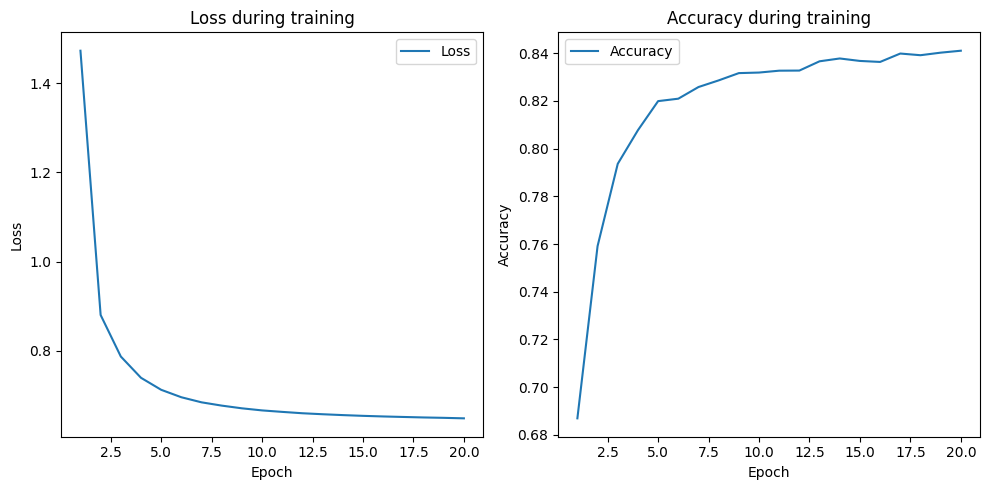

In [33]:
import matplotlib.pyplot as plt

def plot_history(losses, accuracies):
    epochs = range(1, len(accuracies) + 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Loss')
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(losses, accuracies)


### 附：repo链接：https://github.com/sidongxi1/NNDL-hw1